In [83]:
import numpy as np
import pandas as pd
from importlib import reload
from pylab import plt
from sklearn.preprocessing import PowerTransformer

import utils; reload(utils)

<module 'utils' from '/Users/kizawamasakazu/projects/machine_learning/work/time_series/stock_price_prediction/n225/utils.py'>

array([[<AxesSubplot: title={'center': 'Close'}>,
        <AxesSubplot: title={'center': 'High'}>],
       [<AxesSubplot: title={'center': 'Low'}>,
        <AxesSubplot: title={'center': 'Open'}>],
       [<AxesSubplot: title={'center': 'Volume'}>, <AxesSubplot: >]],
      dtype=object)

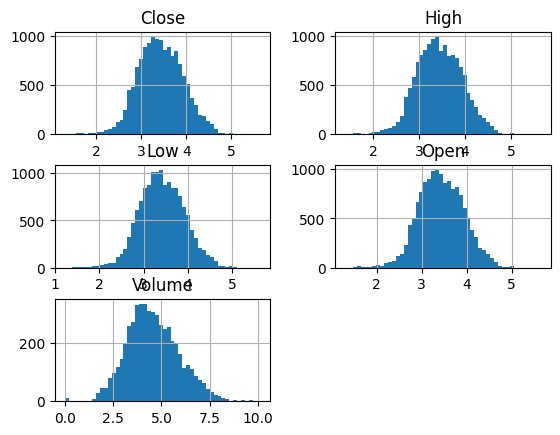

In [84]:
# N225株価データ
from fracdiff.sklearn import Fracdiff

df = pd.read_csv('N225.csv')
df['log_return'] = np.log(df['Close']).diff()
df['y'] = df['log_return'].shift(-1)
# df['y'] = df['Adj Close'].shift(-1)
columns = ['Close', 'High', 'Low', 'Open', 'Volume']
for column in columns:
    df[f'{column}_std'] = df[column].ewm(halflife=15).std()
    df[f'{column}_mean'] = df[column].ewm(halflife=15).mean()
    df[column] = df[column] / df[f'{column}_std']
    if column != "Volume":
        df[column] = np.log(df[column])
        # df[column] = df[column] - df[column].ewm(halflife=15)

df[columns].hist(bins=50)

In [85]:
import torch
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, X, y):
        assert len(X) == len(y)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx) -> np.ndarray:
        return self.X[idx], self.y[idx]

def make_dataset(df, seqlen):
    X = df[['log_return']].values
    y = df['y'].values
    
    datalen = X.shape[0]
    Xs, ys = [], []  
    for i in range(datalen-seqlen+1):
        Xs.append(X[i:i+seqlen,:])
        ys.append(y[i:i+1])
    Xs = np.stack(Xs)
    ys = np.stack(ys)
    return MyDataset(Xs, ys)

# scaling
minmax_scaler = MinMaxScaler()
std_scaler = StandardScaler()
# scaled_df = pd.DataFrame(index=df.index)
# scaled_df[columns] = minmax_scaler.fit_transform(df[columns])
df['y'] = std_scaler.fit_transform(df[['y']])
df = df.dropna()
train, test = train_test_split(df, test_size=0.2, shuffle=False)
train, val = train_test_split(df, test_size=0.2, shuffle=False)
train_dataset = make_dataset(train, seqlen=60)
val_dataset = make_dataset(val, seqlen=60)
train_dataloader = DataLoader(train_dataset, batch_size=64)
val_dataloader = DataLoader(val_dataset, batch_size=1)
X, y = next(iter(train_dataloader))
print(X.shape, y.shape)

torch.Size([64, 60, 1]) torch.Size([64, 1])


In [86]:
# モデル定義
import torch
import torch.nn as nn
import torch.optim as optimizers
from torch.utils.data import DataLoader

class RNN(nn.Module):

    def __init__(self, input_dim, hidden_dims):
        super().__init__()
        self.l1 = nn.RNN(input_dim, 64, nonlinearity='tanh', batch_first=True)
        self.l2 = nn.Linear(64, 32)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(32, 1)
        
        nn.init.xavier_normal_(self.l1.weight_ih_l0)
        nn.init.orthogonal(self.l1.weight_hh_l0)
        
    def forward(self, x):
        h, _ = self.l1(x)
        y = self.l2(h[:, -1])
        return y

In [87]:
torch.manual_seed(123)
device = torch.device('cpu')

# columns = ['Open', 'High', 'Low', 'Close', 'log_return']
columns = ['log_return']

input_dim = len(columns)
hidden_dim = 64
model = RNN(input_dim, hidden_dim)
optimizer = optimizers.Adam(model.parameters(), lr=0.005)
criterion = nn.L1Loss()

epochs = 10
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)


def compute_loss(y, yhat):
    return criterion(yhat, y)

def train_step(x, y):
    model.train()
    yhat = model(x)
    loss = compute_loss(y, yhat)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return yhat, loss

def val_step(x, y):
    model.eval()
    yhat = model(x)
    loss = compute_loss(y, yhat)
    return yhat, loss

for epoch in range(epochs):
    train_loss = .0
    val_loss = .0
    
    for X, y in train_dataloader:
        _, loss = train_step(X, y)    
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    
    for X, y in val_dataloader:
        _, loss = val_step(X, y)
        val_loss += loss.item()
    val_loss /= len(val_dataset)
    
    print(
        'epoch: {}, train loss: {}, val loss: {}'\
        .format(epoch, train_loss, val_loss)
    )


/var/folders/sv/k4676nzx20ndpwkjt51ctv380000gn/T/ipykernel_58623/2440891113.py:17: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(self.l1.weight_hh_l0)
/Users/kizawamasakazu/.pyenv/versions/3.9.16/lib/python3.9/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/Users/kizawamasakazu/.pyenv/versions/3.9.16/lib/python3.9/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([57, 1])) that is different to the input size (torch.Size([57, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/Users/kizawamasakazu/.pyen

epoch: 0, train loss: 0.8213189244270325, val loss: 0.7254399545752822
epoch: 1, train loss: 0.8189132051034407, val loss: 0.7317964923965871
epoch: 2, train loss: 0.8172611901254365, val loss: 0.7267384801565403
epoch: 3, train loss: 0.818106188918605, val loss: 0.7264050021524255
epoch: 4, train loss: 0.8166476054625078, val loss: 0.7255066484877437
epoch: 5, train loss: 0.8240802884101868, val loss: 0.73850442457888
epoch: 6, train loss: 0.8355547135526483, val loss: 0.7365608102337798
epoch: 7, train loss: 0.844001363624226, val loss: 0.7519259032142821
epoch: 8, train loss: 0.8352266911304358, val loss: 0.7416880214334133
epoch: 9, train loss: 0.8335788249969482, val loss: 0.7731234996687227


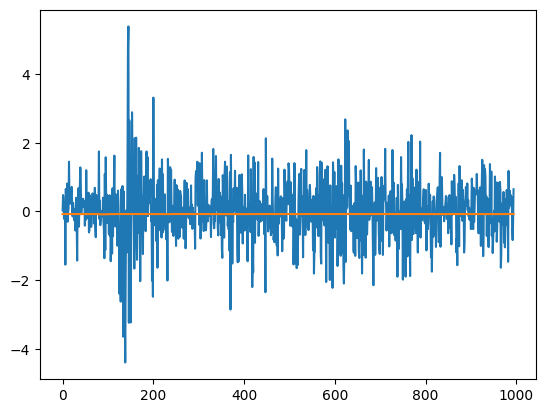

In [68]:
from sklearn.metrics import precision_score, recall_score

ytrues = []
ypreds = []
for X, y in val_dataloader:
    model.eval()
    ypred = model(X)
    ypreds.append(ypred.flatten().detach())
    ytrues.append(y.flatten())
    
ypreds = torch.cat(ypreds)
ytrues = torch.cat(ytrues)

plt.plot(ytrues)
plt.plot(ypreds)

In [49]:
precision_score(ytrues > 0, ypreds > 0)

0.5253521126760563